In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy.random as nprand
import pandas as pd 
import copy
import tqdm


from AC_simulation import simulation

In [2]:
def mask_constructor(mask, r):
    mask.add_sphere(r* 0.3, shift = [-2, 2, -3])
    mask.add_ellipsoid(0.5, 0.7, 0.5, r)
    mask.add_ellipsoid(0.5, 0.5, 1.5, r, shift = [4,-3 , 2])
    mask.add_ellipsoid(0.4, 1.2, 0.6, r, shift = [2,-1 , 0])
    mask.rotate(45, 30, 45)
    return mask

elements = 3000

nprand.seed(0)
rand_FWHM = (nprand.rand(elements) * 3) + 3
rand_radius = (nprand.rand(elements) * 6) + 7
rand_A = (nprand.rand(elements) * 40)

sim = simulation(64, 1, elements)
sim.SetActivityConcentration(rand_A)
sim.SetFWHM(rand_FWHM)
sim.SetTargetArgs(rand_radius)
sim.SetTargetConstructor(mask_constructor)
data = sim.Run()

100%|██████████| 3000/3000 [00:55<00:00, 53.57it/s]


In [5]:
data.head()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
0,4.646441,2184.0,1.648302,10.727288,14.991741,7.832153,0.074972,0.023229,0.043478,0.054722,0.048980,0.049220
1,5.145568,3132.0,1.555887,12.383358,17.147439,7.540015,0.110048,0.029254,0.062844,0.076458,0.068510,0.070792
2,4.808290,3818.0,1.502558,20.553609,27.322265,12.509762,0.170636,0.052562,0.103536,0.119662,0.109031,0.114166
3,4.634650,4254.0,1.479138,18.470372,24.037912,11.277715,0.163148,0.044087,0.096097,0.111138,0.100972,0.106263
4,4.270964,4028.0,1.485251,2.201356,2.819319,1.445838,0.016638,0.005146,0.010027,0.011757,0.010668,0.011117


In [6]:
data.describe()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.512720,2647.334333,1.660049,14.340701,19.753285,10.568518,0.102355,0.030833,0.059877,0.073311,0.066136,0.067051
std,0.876789,1207.449744,0.161352,8.458225,11.560741,6.553644,0.066161,0.019452,0.039271,0.046332,0.042086,0.043453
min,3.000221,966.000000,1.450546,0.004457,0.006015,0.002246,0.000046,0.000012,0.000027,0.000031,0.000028,0.000030
25%,3.774160,1573.000000,1.515546,7.019405,9.363649,5.033843,0.046688,0.014244,0.027280,0.033725,0.030371,0.030760
50%,4.502280,2418.000000,1.625000,14.284691,19.757028,10.304113,0.096357,0.029518,0.056004,0.070140,0.063033,0.063194
75%,5.282490,3599.000000,1.787500,21.327871,29.702369,15.411153,0.148216,0.045214,0.087094,0.107053,0.096524,0.097289
max,5.999892,5309.000000,2.062762,32.706769,39.999118,28.181212,0.321097,0.085852,0.191942,0.213619,0.196236,0.209325


## DNN Model
### Data preparation
The data is divided up into training and test sets. The labels, *A_true*, is removed from the parameter data. The dataframes are transformed into tensors to be compatible with pytorch.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

data.drop("analytical")

df_train = data.dropna().sample(frac=0.8, random_state=0)
df_test = data.dropna().drop(df_train.index)

train_labels = df_train.pop("A_true")
test_labels = df_test.pop("A_true")

In [8]:
x_train = torch.tensor(df_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(train_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

x_test = torch.tensor(df_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(test_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

input_features = x_train.shape[1]
print(x_train.shape, y_train.shape)

torch.Size([2400, 11]) torch.Size([2400, 1])


### Defining the network
nn.Sequential defines a simple network. *Linear* is a standard fully connected DNN layer and *ReLU* is the rectified linear unit function (0 if x < 0 else x).

*L1Loss*: mean absolute error

*Adam*: Adaptive moment estimation. *lr*: Learning rate, factor determining how large the change to the new weights is each epoch.

Batch size is the number of features passed through the model and the loss averaged before the model is updated.

In [17]:
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    # nn.Linear(64, 64),
    # nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss() #nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 200   # number of epochs to run
batch_size = 10  # size of each batch

In [18]:
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_error = np.inf   # init to infinity
best_weights = None
history = []
loss_history = []

with tqdm.tqdm(range(n_epochs), disable = False, unit="epochs") as epoch_bar:
    for epoch in epoch_bar:
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description("Epoch {:>3}".format(epoch))
            for start in bar:
                # take a batch
                X_batch = x_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad() # Reset gradient
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(error=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(x_test)
        error = loss_fn(y_pred, y_test)
        error = float(error)
        loss_history.append(float(loss))
        history.append(error)
        
        epoch_bar.set_postfix(loss_error = (round(float(loss), 5), round(float(error), 5)))
        if error < best_error:
            best_error = error
            best_weights = copy.deepcopy(model.state_dict())

100%|██████████| 200/200 [00:35<00:00,  5.56epochs/s, loss_error=(0.06099, 0.07351)]


Best Error: 0.0254


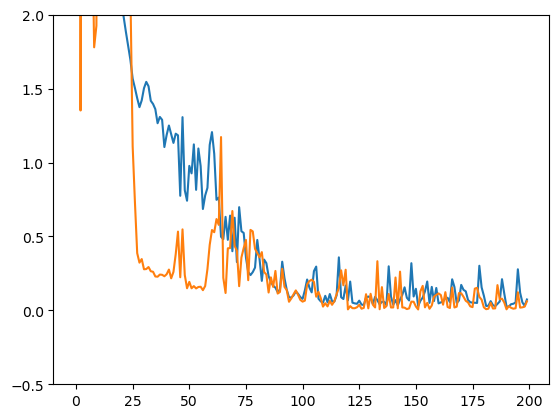

In [19]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("Best Error: %.4f" % best_error)
plt.plot(history)
plt.plot(loss_history)
plt.ylim(-0.5, 2)
plt.show()

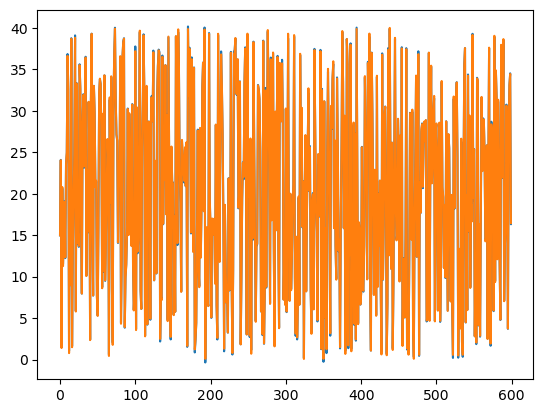

In [33]:
model.eval()
prediction = model(x_test)

with torch.no_grad():
    plt.figure()
    plt.plot(range(len(prediction.reshape(-1))), prediction.reshape(-1))
    plt.plot(range(len(prediction.reshape(-1))), y_test.reshape(-1))
    plt.show()

## Verification

To check how well the model handels unknown data new data is generated and the parameters are used to predict the true activity.

In [34]:
from numpy.random import rand

elements = 500

rand_FWHM = (nprand.rand(elements) * 3) + 3
rand_radius = (nprand.rand(elements) * 6) + 7
rand_A = (nprand.rand(elements) * 40)

sim = simulation(64, 1, elements)
sim.SetActivityConcentration(rand_A)
sim.SetFWHM(rand_FWHM)
sim.SetTargetArgs(rand_radius)
sim.SetTargetConstructor(mask_constructor)
ver_data = sim.Run(multiprocessing=False)

ver_data.sort_values(by="A_true", inplace=True)
ver_labels = ver_data.pop("A_true")

ver_x = torch.tensor(ver_data.to_numpy(), dtype=torch.float32)
ver_y = torch.tensor(ver_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

model.eval()
prediction = model(ver_x)

100%|██████████| 500/500 [00:39<00:00, 12.70it/s]


Mean absolute error: tensor(0.1188)


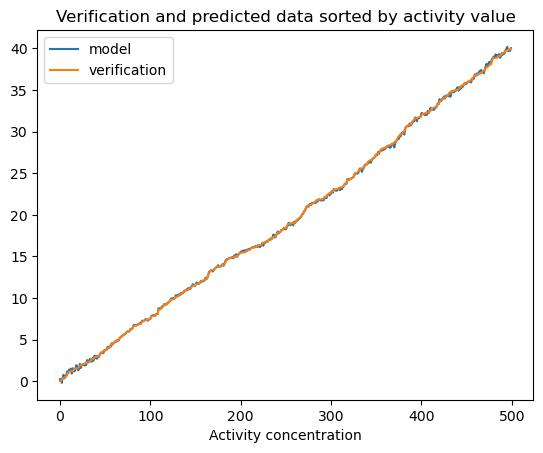

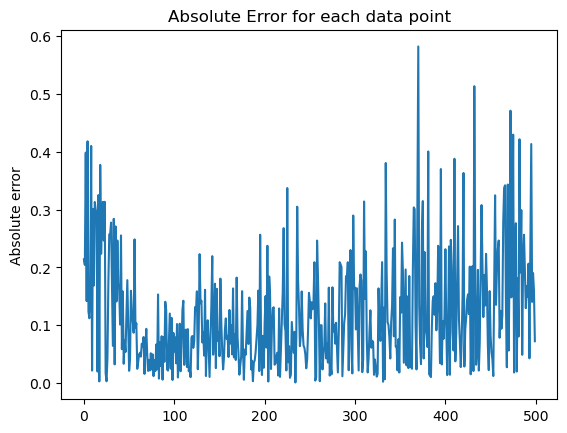

In [42]:

with torch.no_grad():
    
    print("Mean absolute error:", torch.mean(torch.abs(ver_y - prediction)))
    
    plt.figure()
    plt.title("Verification and predicted data sorted by activity value")
    plt.xlabel("Activity concentration")
    plt.plot(range(len(prediction.reshape(-1))), prediction, label = "model")
    plt.plot(range(len(prediction.reshape(-1))), ver_y, label = "verification")
    plt.legend()
    plt.show()
    plt.figure()
    plt.title("Absolute Error for each data point")
    plt.ylabel("Absolute error")
    plt.plot(range(len(prediction.reshape(-1))), torch.abs(ver_y - prediction))
    plt.show()